In [39]:
import os
import gc
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [20]:
# Add after imports
tf.keras.mixed_precision.set_global_policy('mixed_float16')
gc.enable()

In [21]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Clear memory between training phases
import gc
gc.collect()
tf.keras.backend.clear_session()

In [22]:
def verify_processed_data():
    """Verify processed and augmented data structure"""
    data_paths = {
        'train': '../data/processed/train',
        'validation': '../data/processed/validation',
        'test': '../data/processed/test',
        'augmented': '../data/processed/train_augmented'
    }
    
    for split, path in data_paths.items():
        print(f"\nChecking {split} directory:")
        if not os.path.exists(path):
            print(f"Warning: {split} directory not found at {path}")
            continue
            
        classes = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
        print(f"Found {len(classes)} classes")
        
        for cls in classes:
            class_path = os.path.join(path, cls)
            n_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
            print(f"- {cls}: {n_images} images")

# Run verification
verify_processed_data()


Checking train directory:
Found 39 classes
- Apple___Apple_scab: 442 images
- Apple___Black_rot: 435 images
- Apple___Cedar_apple_rust: 193 images
- Apple___healthy: 1153 images
- Blueberry___healthy: 1052 images
- Cherry_(including_sour)___healthy: 598 images
- Cherry_(including_sour)___Powdery_mildew: 738 images
- Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 361 images
- Corn_(maize)___Common_rust_: 836 images
- Corn_(maize)___healthy: 814 images
- Corn_(maize)___Northern_Leaf_Blight: 691 images
- Grape___Black_rot: 826 images
- Grape___Esca_(Black_Measles): 969 images
- Grape___healthy: 297 images
- Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 754 images
- Orange___Haunglongbing_(Citrus_greening): 3855 images
- Peach___Bacterial_spot: 1609 images
- Peach___healthy: 252 images
- Pepper,_bell___Bacterial_spot: 699 images
- Pepper,_bell___healthy: 1036 images
- plant_village_dataset: 0 images
- Potato___Early_blight: 700 images
- Potato___healthy: 108 images
- Potato___Late_blig

In [23]:
train_dir = '../data/processed/train_augmented'
val_dir = '../data/processed/validation'
test_dir = '../data/processed/test'
model_save_path = '../models/saved_models/'
os.makedirs(model_save_path, exist_ok=True)


In [24]:

# First, verify the data paths and structure
def verify_data_directories():
    paths = {
        'train_augmented': train_dir,
        'validation': val_dir,
        'test': test_dir
    }
    
    for name, path in paths.items():
        print(f"\nChecking {name} directory: {path}")
        print(f"Directory exists: {os.path.exists(path)}")
        if os.path.exists(path):
            classes = os.listdir(path)
            print(f"Found classes: {classes}")
            for class_name in classes:
                class_path = os.path.join(path, class_name)
                if os.path.isdir(class_path):
                    n_images = len([f for f in os.listdir(class_path) 
                                  if f.endswith(('.jpg', '.jpeg', '.png'))])
                    print(f"- {class_name}: {n_images} images")


In [25]:
img_width, img_height = 96, 96
batch_size = 4
initial_epochs = 2
fine_tune_epochs = 1
verify_data_directories()


Checking train_augmented directory: ../data/processed/train_augmented
Directory exists: True
Found classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'plant_village_dataset', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___h

In [26]:
class_names = os.listdir(train_dir)
num_classes = len(class_names)
print(f"Training with {num_classes} classes: {class_names}")

Training with 39 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'plant_village_dataset', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [28]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [29]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 38047 images belonging to 39 classes.


In [30]:
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8129 images belonging to 39 classes.


In [31]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 8129 images belonging to 39 classes.


In [32]:
# Define model using transfer learning
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import gc
try:
    # Clear memory and session
    tf.keras.backend.clear_session()
    gc.collect()
    
    base_model = MobileNetV2(weights='imagenet', 
                            include_top=False, 
                            input_shape=(img_width, img_height, 3))
    
    base_model.trainable = False

    # Reduce dense layer size
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)  # Reduced from 1024
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    checkpoint = ModelCheckpoint(
        os.path.join(model_save_path, 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
    callbacks = [checkpoint, early_stopping, reduce_lr]
    print("Model and callbacks defined successfully")
except Exception as e:
    print(f"Error in model definition: {str(e)}")
    raise

Model and callbacks defined successfully


In [33]:
# Train the model
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=initial_epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=callbacks
    )
except Exception as e:
    print(f"Error during training: {str(e)}")
    raise


Epoch 1/2


c:\Users\laksh\Crop-disease-detection\crop_disease_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  59/9511 ━━━━━━━━━━━━━━━━━━━━ 2:49 18ms/step - accuracy: 0.1538 - loss: 4.3038

KeyboardInterrupt: 

In [ ]:

# Fine-tune the model: unfreeze some layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with unfrozen layers
fine_tune_epochs = 1
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks
)

# Save the final model
try:
    model.save(os.path.join(model_save_path, 'final_model.h5'))
    print("Model saved successfully")
except Exception as e:
    print(f"Error saving model: {e}")

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

Epoch 2/3
9511/9511 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4583 - loss: 2.7069
Epoch 2: val_accuracy did not improve from 0.84313
9511/9511 ━━━━━━━━━━━━━━━━━━━━ 693s 72ms/step - accuracy: 0.4584 - loss: 2.7068 - val_accuracy: 0.8312 - val_loss: 0.6490 - learning_rate: 1.0000e-05
Epoch 3/3
   1/9511 ━━━━━━━━━━━━━━━━━━━━ 13:23 85ms/step - accuracy: 0.7500 - loss: 0.7068
Epoch 3: val_accuracy did not improve from 0.84313
9511/9511 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.7500 - loss: 0.7068 - val_accuracy: 0.8312 - val_loss: 0.6492 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 2.


Model saved successfully
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 89s 44ms/step - accuracy: 0.8449 - loss: 0.6234
Test accuracy: 0.8360


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 6,697,783 (25.55 MB)

 Trainable params: 1,881,959 (7.18 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

 Optimizer params: 3,763,920 (14.36 MB)

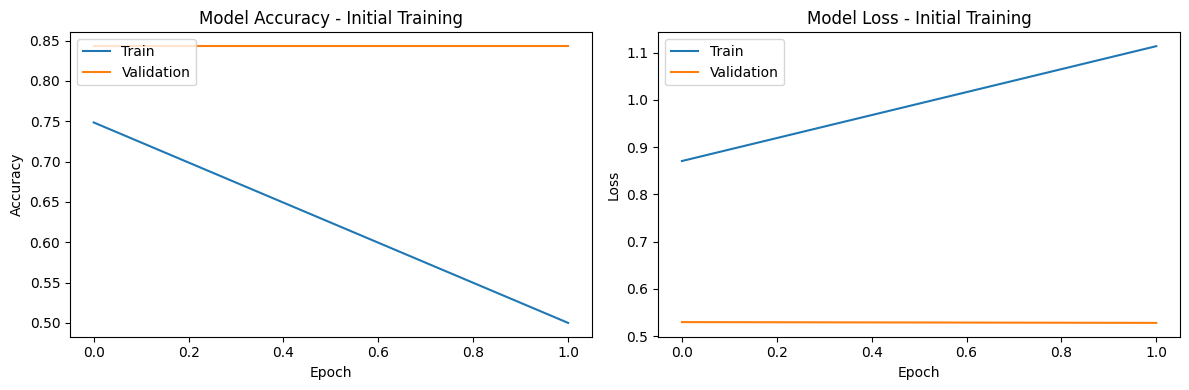

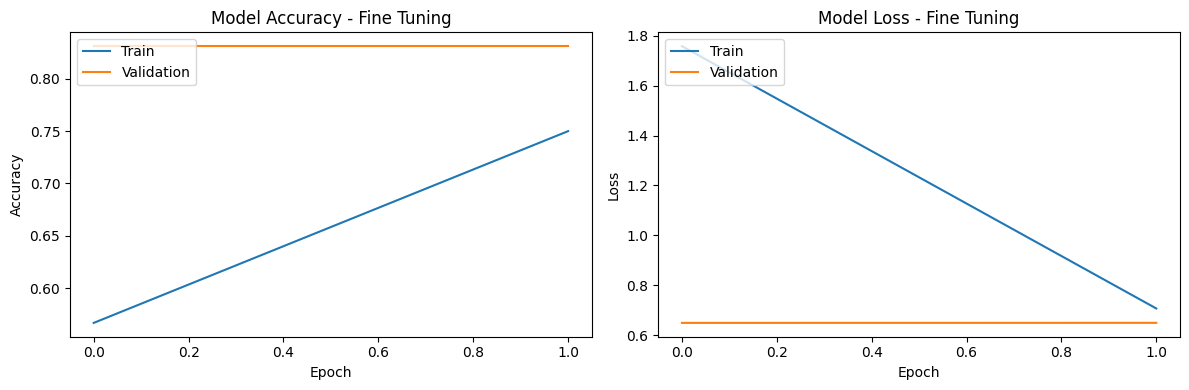

In [ ]:
# Add after model definition
model.summary()

# Training history plotting function
def plot_training_history(history, title_suffix=""):
    if not history.history:
        print("No training history available.")
        return
    try:
        plt.figure(figsize=(12, 4))
        
        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'Model Accuracy {title_suffix}')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'Model Loss {title_suffix}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting training history: {e}")

# Add after initial training
plot_training_history(history, "- Initial Training")

# Add after fine-tuning
plot_training_history(history_fine, "- Fine Tuning")

In [ ]:
# Add this cell to verify data structure
# Ensure directories are defined
import os
train_dir = '../data/processed/train_augmented'

for directory in [train_dir, val_dir, test_dir]:
    if not os.path.exists(directory):
        print(f"Missing directory: {directory}")
    else:
        classes = os.listdir(directory)
        print(f"\nDirectory {directory}:")
        print(f"Number of classes: {len(classes)}")
        print(f"Classes: {classes}")


Directory ../data/processed/train_augmented:
Number of classes: 39
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'plant_village_dataset', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight',

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
def evaluate_model(model, test_generator):
    try:
        # Reset the generator
        test_generator.reset()
        
        # Get predictions
        predictions = model.predict(
            test_generator,
            steps=len(test_generator),
            verbose=1
        )
        
        # Get predicted classes
        predicted_classes = np.argmax(predictions, axis=1)
        
        # Get true classes
        true_classes = test_generator.classes
        
        # Get class labels
        class_labels = list(test_generator.class_indices.keys())
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(
            true_classes,
            predicted_classes,
            target_names=class_labels,
            zero_division=0
        ))
        
        # Plot confusion matrix
        plt.figure(figsize=(12, 8))
        cm = confusion_matrix(true_classes, predicted_classes)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels,
                    yticklabels=class_labels)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error in evaluate_model: {str(e)}")
        raise


In [ ]:
# After model training and fine-tuning completes

# Get class labels directly from the test generator's class indices
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())

# Remove the 'plant_village_dataset' class if it exists
if 'plant_village_dataset' in class_labels:
	class_labels.remove('plant_village_dataset')

evaluate_model(model, test_generator)
    

In [ ]:
# Save training history
import json
history_dict = {
    'initial_training': {
        'accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'],
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    },
    'fine_tuning': {
        'accuracy': history_fine.history['accuracy'],
        'val_accuracy': history_fine.history['val_accuracy'],
        'loss': history_fine.history['loss'],
        'val_loss': history_fine.history['val_loss']
    }
}

with open(os.path.join(model_save_path, 'training_history.json'), 'w') as f:
    json.dump(history_dict, f)